# Import

In [33]:
import matplotlib.pyplot as plt
from os.path import join
from matplotlib.ticker import FuncFormatter, MultipleLocator, StrMethodFormatter, ScalarFormatter

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

In [34]:
import sys, gc
sys.path.append('..')
from Class.PlotConfig import *

# Input

## Attention

In [35]:
root = '../scratch/TFT_baseline/figures/'
attention = pd.read_csv(join(root, 'attention.csv'))
attention['Date'] = pd.to_datetime(attention['Date'])
attention.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,Date,FIPS
0,0.005,0.022,0.177,0.004,0.008,0.038,0.490,0.093,0.067,0.069,0.003,0.007,0.018,2020-03-13,10001
1,0.129,0.001,0.010,0.057,0.023,0.101,0.336,0.089,0.001,0.009,0.062,0.026,0.155,2020-03-14,10001
2,0.091,0.018,0.003,0.006,0.150,0.064,0.395,0.041,0.008,0.002,0.004,0.131,0.088,2020-03-15,10001


In [36]:
max_encoder_length = 13
encoder_indices = list(range(max_encoder_length))
attention.rename(
    {str(index):index for index in encoder_indices}, 
    axis=1, inplace=True
)

## Ground Truth

In [4]:
predictions = pd.read_csv(join(root, 'predictions.csv'))
predictions['Date'] = pd.to_datetime(predictions['Date'])
predictions['weekday'] = predictions.Date.dt.dayofweek

# analyzing against train attention weights
predictions = predictions[predictions['split']=='train']

predictions_summed_by_county = predictions.groupby(
    ['FIPS'])[['Cases']].aggregate('sum').reset_index()

predictions_summed_by_date = predictions.groupby(
    ['Date', 'weekday'])[['Cases']].aggregate('sum').reset_index()

predictions.head(3)

,FIPS,TimeFromStart,Predicted_Cases,Cases,Date,split,weekday
0,10001,13,7.0,0.0,2020-03-13,train,4
1,10003,13,17.0,0.0,2020-03-13,train,4
2,10005,13,9.0,0.0,2020-03-13,train,4


In [47]:
prediction_weekly_sum = predictions.groupby(
    ['weekday']
)['Cases'].aggregate('sum').reset_index()

prediction_weekly_mean = predictions.groupby(
    ['weekday']
)['Cases'].aggregate('mean').reset_index()

# Temporal

## Preprocess

In [37]:
attention_date_aligned = pd.DataFrame(attention[['FIPS', 'Date']])
for i in range(max_encoder_length):
    attention_date_aligned[i] = attention[i].shift(
        periods=i-max_encoder_length, fill_value=0
    )

attention_date_aligned['weekday'] = attention_date_aligned.Date.dt.dayofweek

In [38]:
attention_date_aligned_summed = attention_date_aligned.groupby('Date')[
    encoder_indices
].aggregate('sum').reset_index()

attention_date_aligned_mean = attention_date_aligned.groupby('Date')[
    encoder_indices
].aggregate('mean').reset_index()

gc.collect()

12858

## Attention vs Date

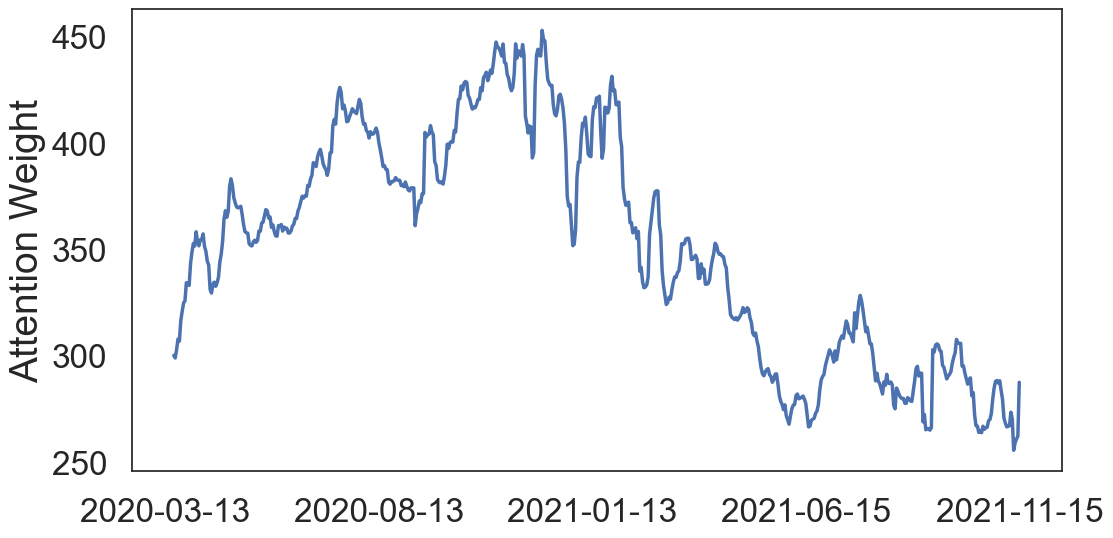

In [72]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    attention_date_aligned_summed['Date'],
    attention_date_aligned_summed[12].rolling(7, axis=0).mean()
)
x_first_tick = attention_date_aligned_summed['Date'].min()
x_last_tick = attention_date_aligned_summed['Date'].max()
x_major_ticks = 5
ax.set_xticks(
    [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) 
     for i in range(x_major_ticks)]
)
ax.set_ylabel('Attention Weight')
plt.show()

## Attention vs Weekday

In [177]:
weekdays = ['Mon', 'Tues', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
attention_weekly_sum = attention_date_aligned.groupby(
    ['weekday'])[encoder_indices].aggregate('sum').reset_index()

attention_date_aligned.head(3)

,FIPS,Date,0,1,2,3,4,5,6,7,8,9,10,11,12,weekday
0,10001,2020-03-13,0.013,0.063,0.045,0.034,0.233,0.200,0.532,0.021,0.051,0.014,0.009,0.131,0.155,4
1,10001,2020-03-14,0.016,0.017,0.069,0.062,0.043,0.083,0.331,0.083,0.082,0.068,0.072,0.053,0.088,5
2,10001,2020-03-15,0.232,0.083,0.049,0.042,0.083,0.135,0.413,0.093,0.061,0.134,0.020,0.069,0.109,6


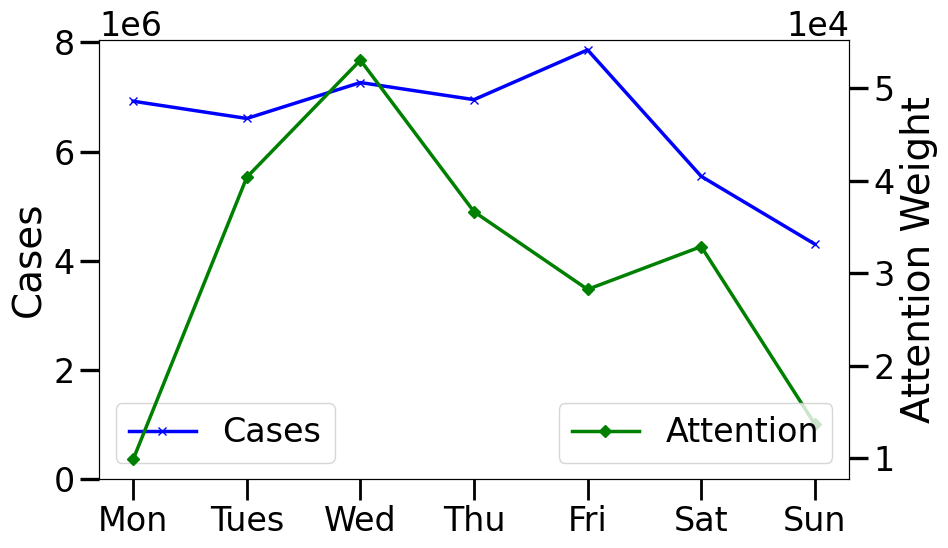

In [178]:
# from matplotlib.ticker import StrMethodFormatter
# formatter = StrMethodFormatter('{x:,.3g}')
# weight_formatter = FuncFormatter(lambda x, _: '{0:g}'.format(x/1e3))
formatter = ScalarFormatter(useOffset=True)
formatter.set_powerlimits((-3, 3))

fig, ax = plt.subplots(figsize=(10, 6))
line_1 = ax.plot(
    prediction_weekly_sum['weekday'], prediction_weekly_sum['Cases'],
    marker='x', label='Cases', color='blue'
    
)
second_axis = ax.twinx()
line_2 = second_axis.plot(
attention_weekly_sum['weekday'], attention_weekly_sum[max_encoder_length-1],
    marker='D', label='Attention', color='green'
)

ax.set_ylim(bottom=0)
ax.set_ylabel('Cases')
second_axis.set_ylabel('Attention Weight')
second_axis.yaxis.set_major_formatter(formatter)

ax.set_xticks(range(len(weekdays)))
ax.set_xticklabels(weekdays)

ax.legend(loc='lower left')
second_axis.legend(loc='lower right')

fig.tight_layout()
plt.show()

## Seasonality in Attention

### By Position Index

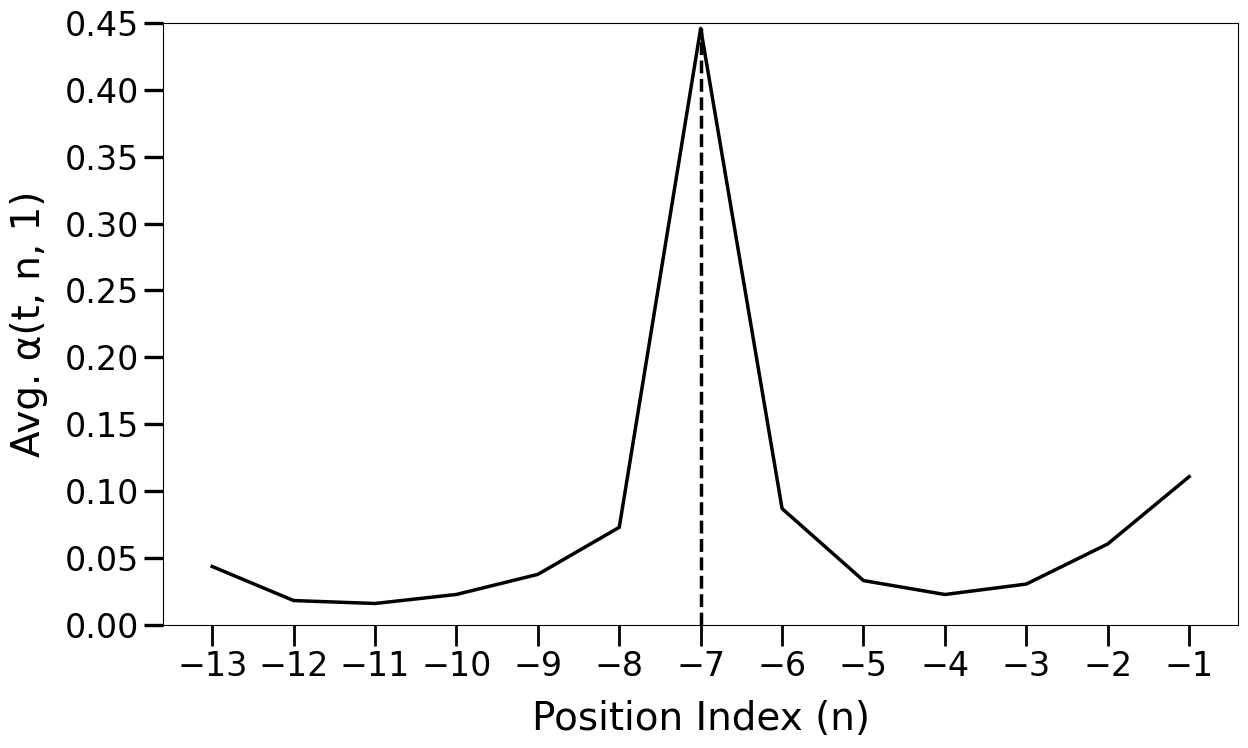

In [32]:
fig, ax = plt.subplots(figsize=(13, 8))

ax.plot(
    np.array(encoder_indices) - max_encoder_length,
    attention_date_aligned_mean[encoder_indices].mean(),
    color='black'
)
ax.set_ylim(0, .45)
ax.set_xlabel("Position Index (n)", labelpad=12)
# ax.set_ylabel("Attention Weight")
ax.set_ylabel('Avg. α(t, n, 1)', labelpad=12)

ax.vlines(
    -7, 0, attention_date_aligned_mean[6].mean(),
    color='black', linestyles='--'
)

ax.xaxis.set_major_locator(MultipleLocator(base=1))
fig.tight_layout() # might change y axis values
plt.savefig(join(root, 'Train_attention.jpg'), dpi=200)
plt.show()

### By Dates

In [39]:
start_date = pd.to_datetime('2020-11-24')
end_date = pd.to_datetime('2021-01-02')

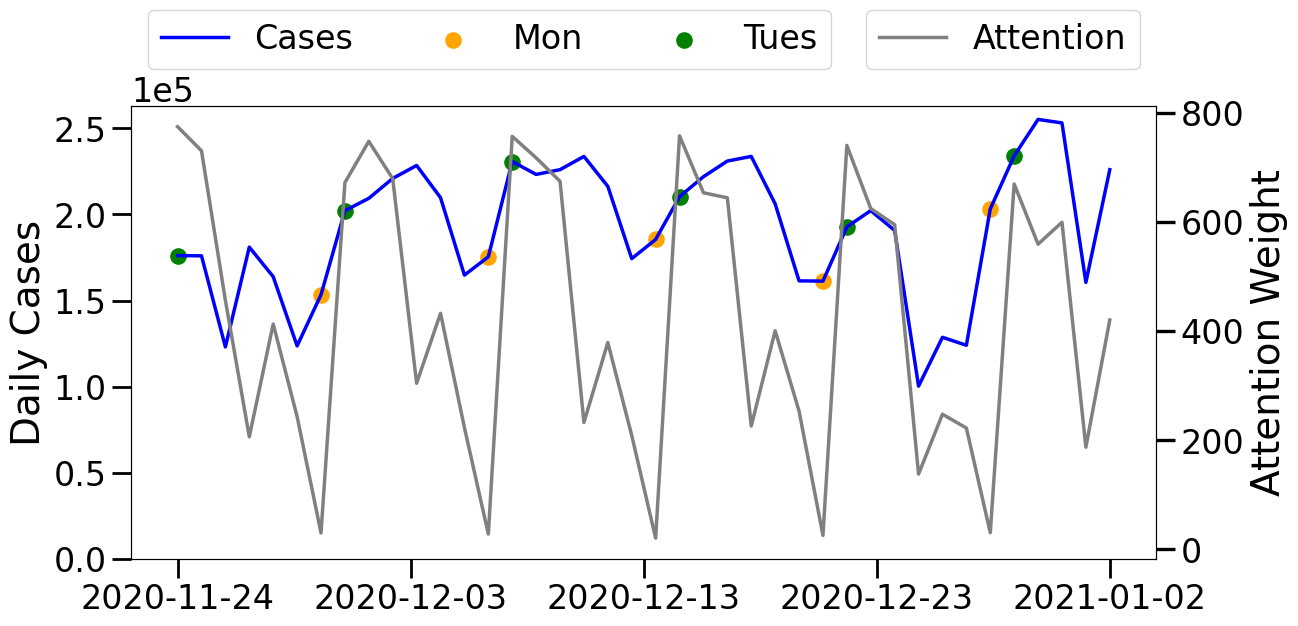

In [209]:
# from matplotlib.ticker import StrMethodFormatter
# formatter = StrMethodFormatter('{x:,.3g}')
# weight_formatter = FuncFormatter(lambda x, _: '{0:g}'.format(x/1e3))
formatter = ScalarFormatter(useOffset=True)
formatter.set_powerlimits((-3, 3))

fig, ax = plt.subplots(figsize=(13.5, 7))
df1 = predictions_summed_by_date[
    (predictions_summed_by_date['Date']>=start_date) & 
    (predictions_summed_by_date['Date']<=end_date)
]
ax.plot(
    df1['Date'], df1['Cases'],
    label='Cases', color='blue'  
)
for index, color in zip([0, 1], ['orange', 'green']):
    weekday = weekdays[index]
    data = df1[df1['weekday']==index]
    ax.scatter(
        data['Date'], data['Cases'],
        marker='o', label=weekday, color=color, s=120 
    )

second_axis = ax.twinx()
df2 = attention_date_aligned_summed[
    (attention_date_aligned_summed['Date']>=start_date) & 
    (attention_date_aligned_summed['Date']<=end_date)
]
second_axis.plot(
    df2['Date'], df2[max_encoder_length-1],
   label='Attention', color='gray'
)

ax.set_ylim(bottom=0)
ax.set_ylabel('Daily Cases')
ax.yaxis.set_major_formatter(formatter)
second_axis.set_ylabel('Attention Weight')

# x_first_tick = predictions_summed_by_date['Date'].min()
# x_last_tick = predictions_summed_by_date['Date'].max()

x_major_ticks = DATE_TICKS
ax.set_xticks(
    [start_date + (end_date - start_date) * i / (x_major_ticks - 1) for i in range(x_major_ticks)]
)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=14)
# ax.tick_params(which='minor', length=16, color='r')

ax.legend(
    ncol=3, bbox_to_anchor = (0, 1.25),
    loc='upper left'
)
second_axis.legend(
    bbox_to_anchor = (1, 1.25), loc='upper right'
)

fig.tight_layout()
plt.show()

### By Lagged Auto-correlation

#### Calculate

In [40]:
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

In [202]:
attention_autocorrelation = sm.tsa.acf(
    attention_date_aligned_summed[max_encoder_length-1], nlags=21
) 
attention_autocorrelation

array([ 1.        ,  0.29850266, -0.25427931, -0.24813802, -0.2507289 ,
       -0.2549913 ,  0.29642372,  0.97153259,  0.28881562, -0.2590242 ,
       -0.25071432, -0.25381535, -0.25756636,  0.29436193,  0.9573063 ,
        0.28678896, -0.25949274, -0.24886449, -0.25395051, -0.25996478,
        0.29359531,  0.93714362])

#### Default plotter

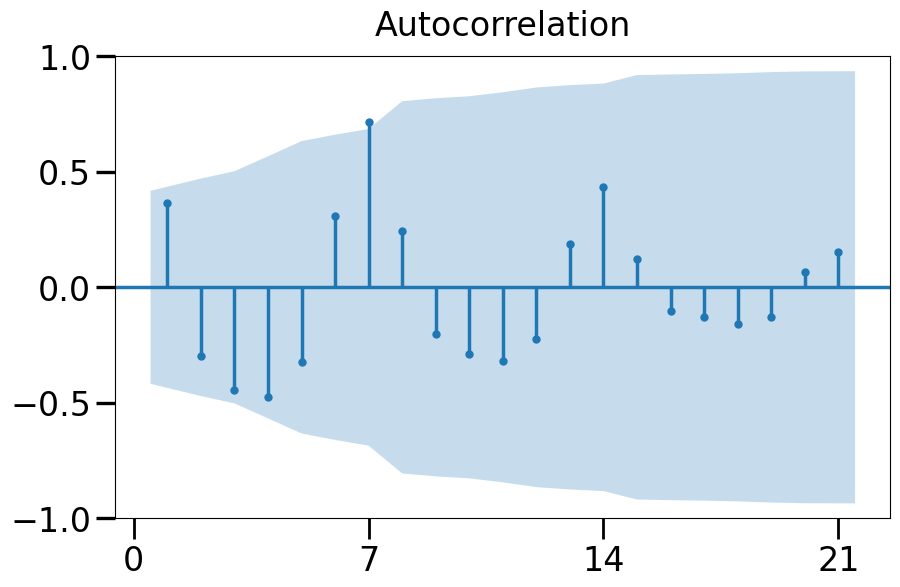

In [203]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.xaxis.set_major_locator(MultipleLocator(base=7))
# ax.tick_params(which='both', width=2, color='r')
# ax.tick_params(which='major', length=8, color='r')
# ax.tick_params(which='minor', length=4, color='r')

# https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html
_ = tsaplots.plot_acf(
    attention_autocorrelation, 
    ax, lags=21, zero=False, alpha=0.05
)

#### Custom plotter

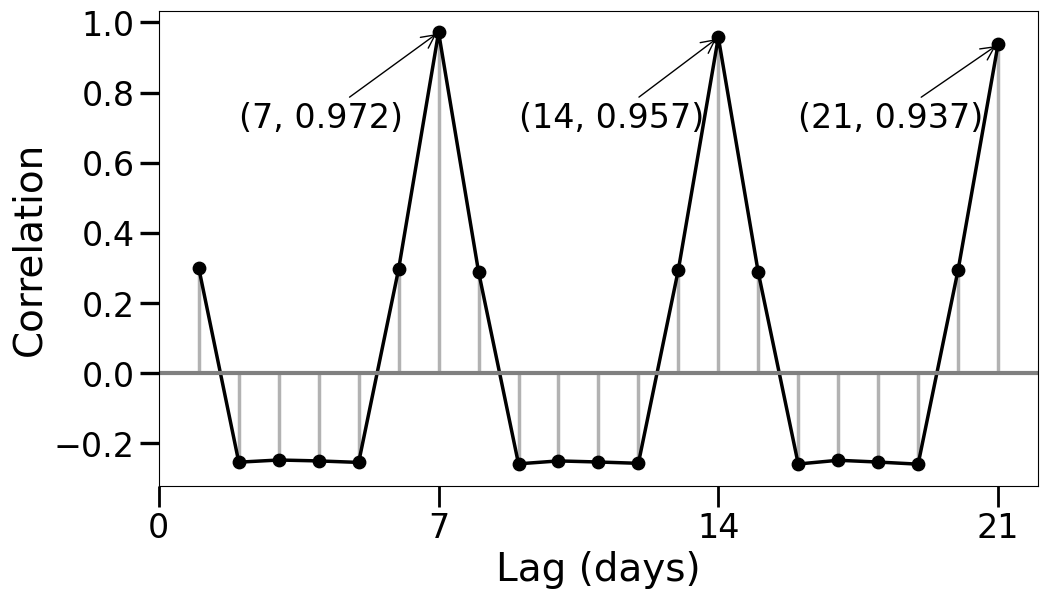

In [204]:
fig, ax = plt.subplots(figsize=(11, 6.5))
# ax.grid(which='major', axis='x')
x, y = range(1, 22), attention_autocorrelation[1:]

ax.xaxis.set_major_locator(MultipleLocator(base=7))
ax.scatter(x, y, s=80, marker='o', color='black')
ax.vlines(
    x,ymin=0, ymax=y, color='black', alpha=0.3
)
ax.plot(x, y, color='black')
ax.axhline(c='grey', lw=3, color='black')
ax.set_ylabel('Correlation')
ax.set_xlabel('Lag (days)')

for index in range(7, 22, 7):
    y = attention_autocorrelation[index]
    ax.annotate(
        text=f"({index}, {np.round(y, 3)})", xy=(index, y),
        xytext=(index-5, 0.7), arrowprops=dict(arrowstyle="->")
    )

fig.tight_layout()

## Seasonality in Cases

In [6]:
case_autocorrelation = sm.tsa.acf(
    predictions_summed_by_date['Cases'], nlags=21
) 
case_autocorrelation

array([1.        , 0.80975706, 0.78196732, 0.79027677, 0.78105479,
       0.76446715, 0.79067898, 0.91265794, 0.7760703 , 0.72824737,
       0.74717776, 0.73222357, 0.70608304, 0.72792128, 0.84038112,
       0.71010179, 0.66343686, 0.68031216, 0.66816126, 0.64175421,
       0.66177952, 0.7662804 ])

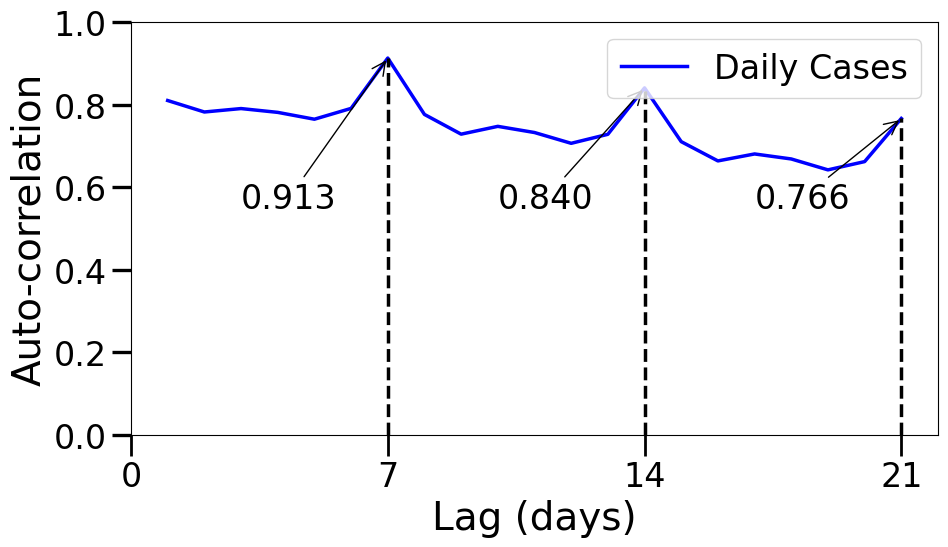

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
# ax.grid(which='major', axis='x')
X, Y = range(1, 22), case_autocorrelation[1:]

ax.xaxis.set_major_locator(MultipleLocator(base=7))

ax.plot(X, Y, color='blue', label='Daily Cases')
ax.set_ylim(0, 1)
# ax.plot(X, attention_autocorrelation[1:], color='green', label='Attention Weight')

# ax.axhline(c='grey', lw=3, color='black')
ax.set_ylabel('Auto-correlation')
ax.set_xlabel('Lag (days)')


for index in range(7, 22, 7):
    y = case_autocorrelation[index]
    ax.annotate(
        text=f"{y:0.3f}", xy=(index, y),
        xytext=(index-4, 0.55), arrowprops=dict(arrowstyle="->"),
    )
    ax.vlines(index, 0, y, color='black', linestyles='--')
    # y = attention_autocorrelation[index]
    # ax.annotate(
    #     text=f"{y:0.3f}", xy=(index, y),
    #     xytext=(index-4, 0.85), arrowprops=dict(arrowstyle="->"),
    # )

ax.legend(
    loc='upper right'
    # ncols=2, bbox_to_anchor = (0.5, 1.2),
    # loc='upper center', framealpha=0.8
)
fig.tight_layout()
fig.savefig(join(root, 'seasonal_pattern.jpg'), dpi=200)

## Cyclic patterns using holiday

https://www.officeholidays.com/countries/usa/2021

In [41]:
import holidays
# Select country
us_holidays = holidays.US()

In [42]:
start_date = pd.to_datetime('2021-11-8')
end_date = pd.to_datetime('2021-12-29')

In [43]:
df = pd.read_csv(join(root, 'predictions.csv'))
df = df.groupby(['Date'])[['Cases', 'Predicted_Cases']].aggregate('sum').reset_index()
df['Date'] = df['Date'].apply(pd.to_datetime)
df['holiday'] = df['Date'].apply(us_holidays.get)

In [46]:
attention_date_aligned_mean.columns

Index(['Date', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='object')

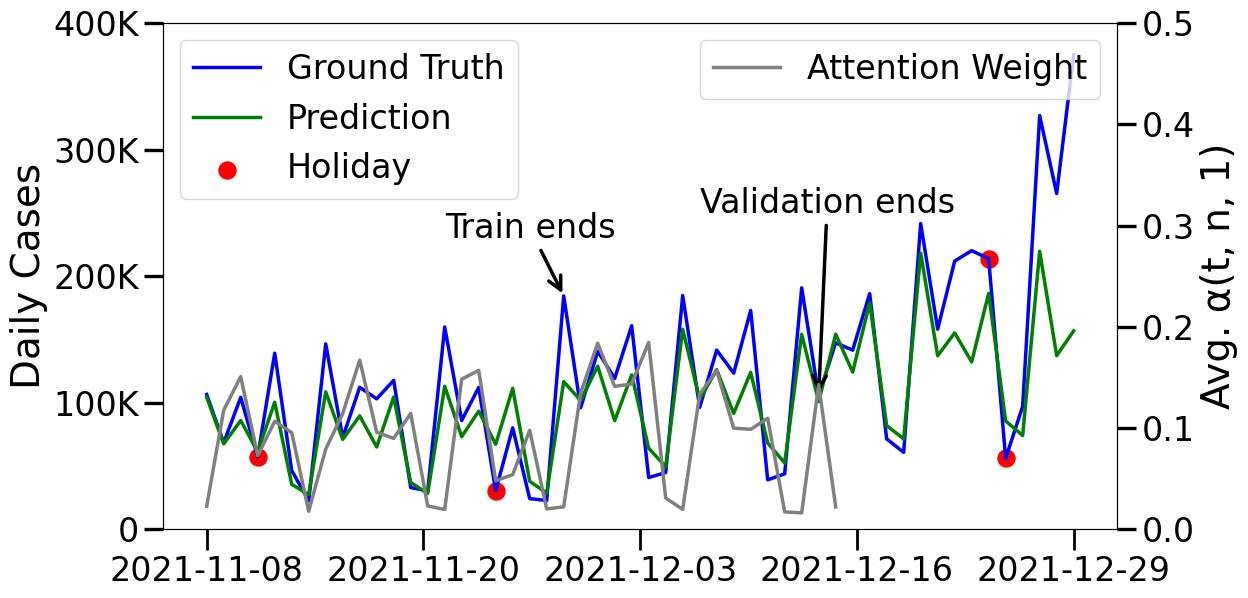

In [59]:
# from matplotlib.ticker import StrMethodFormatter
# formatter = StrMethodFormatter('{x:,.3g}')
# weight_formatter = FuncFormatter(lambda x, _: '{0:g}'.format(x/1e3))

fig, ax = plt.subplots(figsize=(13, 6.5))
df1 = df[(df['Date']>=start_date) & (df['Date']<=end_date)]

ax.plot(
    df1['Date'], df1['Cases'],
    label='Ground Truth', color='blue'  
)
ax.plot(
    df1['Date'], df1['Predicted_Cases'],
    label='Prediction', color='green'  
)

ax2 = ax.twinx()
df2 = attention_date_aligned_mean[
    (attention_date_aligned_mean['Date']>=start_date) & 
    (attention_date_aligned_mean['Date']<=end_date)
]
ax2.plot(
    df2['Date'], df2[12], # .mean(axis=1),
    label='Attention Weight', color='grey'
)
ax2.set_ylim(0, 0.5)
ax2.set_ylabel('Avg. α(t, n, 1)')

holiday_cases = df1[~df1['holiday'].isna()]
ax.scatter(
    holiday_cases['Date'], holiday_cases['Cases'], 
    s=150, marker='o', color='red', label='Holiday'
)
ax.set_ylim(bottom=0)
ax.set_ylabel('Daily Cases')

train_end = pd.to_datetime('2021-11-29')
y = df1[df1['Date']==train_end]['Cases'].values[0]
ax.annotate(
    text=f"Train ends", xy=(pd.to_datetime('2021-11-29'), y),
    xytext=(pd.to_datetime('2021-11-22'), 2.3e5), 
    arrowprops=dict(arrowstyle="->", linewidth=2.5)
)

validation_end = pd.to_datetime('2021-12-14')
y = df1[df1['Date']==validation_end]['Cases'].values[0]
ax.annotate(
    text=f"Validation ends", xy=(validation_end, y),
    xytext=(pd.to_datetime('2021-12-07'), 2.5e5), 
    arrowprops=dict(arrowstyle="->", linewidth=2.5)
)

# x_first_tick = predictions_summed_by_date['Date'].min()
# x_last_tick = predictions_summed_by_date['Date'].max()

x_major_ticks = DATE_TICKS
ax.set_xticks(
    [start_date + (end_date - start_date) * i / (x_major_ticks - 1) 
     for i in range(x_major_ticks)]
)
formatter = ScalarFormatter(useOffset=True)
formatter.set_powerlimits((-3, 3))
ax.yaxis.set_major_formatter(formatter)

label_text = [] 
for loc in ax.get_yticks():
    if loc == 0:
        label_text.append('0')
    else:
        label_text.append(f'{loc/1e3:0.5g}K') 

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(label_text)

ax.legend(ncols=1, loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig(join(root, 'holiday_pattern_index_12.jpg'), dpi=200)
plt.show()

In [249]:
holiday_cases

,Date,Cases,Predicted_Cases,holiday
608,2021-11-11,57349.25,61316.0,Veterans Day
622,2021-11-25,30577.50,67155.0,Thanksgiving
651,2021-12-24,213712.50,186409.0,Christmas Day (Observed)
652,2021-12-25,56046.00,85581.0,Christmas Day
